# GDSC Wrapped 2023 Code.

Author: Abolo Samuel


In [5]:
import calendar
from datetime import datetime
import json
import os
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize



In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Pull Data from disk

In [7]:


def read_files(path="./chat-exports"):

    files = os.listdir("./chat-exports")

    res = {}

    for file in files:
        if not file.endswith('.txt'):
          continue

        fp = os.path.join(path, file)

        content = open(fp, "r").read()

        res[file.replace('.txt', '')] = content

    return res


In [8]:
files = read_files()

# Transform: Splitting data into rows

The messages are in form of text blobs
We need to transform each message into a row: groupchat, timestamp, phone number, message


In [9]:

def split_phone_messages(unprocessed_messages: list):
    phones = []
    messages = []
    for msg in unprocessed_messages:

        splitted = msg.split(":")

        phones.append(splitted[0])

        message = "".join(splitted[1:])
        messages.append(message)

    return phones, messages


def split_to_messages(txt_blob):

    pattern = "\d{2}/\d{2}/\d{4}, \d{2}:\d{2} -"
    dates = re.findall(pattern, txt_blob)

    messages = re.split(pattern, txt_blob)

    # Remove first whiteline
    if messages[0] == '':
        messages = messages[1:]

    # Separate phone numbers from messages
    phones, messages = split_phone_messages(messages)

    return list(zip(dates, phones, messages))


In [10]:
# Testing...
t = files['CLC']
messages = split_to_messages(t)
messages

len(messages)

messages[:10]

[('24/08/2023, 09:43 -',
  ' Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.\n',
  ''),
 ('31/01/2023, 12:31 -',
  ' Tosin (Crowdsource Ambassador) created group "CLC Babcock"\n',
  ''),
 ('31/01/2023, 12:31 -',
  ' New members need admin approval to join this group. Tap to change.\n',
  ''),
 ('24/08/2023, 09:43 -', ' You joined from the community\n', ''),
 ('24/08/2023, 09:43 -', " You're now an admin\n", ''),
 ('03/09/2023, 14:33 -', ' Demilade Osho requested to join.\n', ''),
 ('03/09/2023, 14:34 -', ' Demilade Osho joined from the community\n', ''),
 ('14/09/2023, 15:02 -', ' +234 901 791 7623 requested to join.\n', ''),
 ('14/09/2023, 16:04 -', ' +234 901 791 7623 joined from the community\n', ''),
 ('14/09/2023, 16:16 -', ' +234 901 791 7623 opened a voice chat\n', '')]

In [11]:
all_messages = []

for key, value in files.items():
    messages = split_to_messages(value)

    # Add the Key (Group Chat) to each row
    messages = [(key, *msg) for msg in messages]

    all_messages.extend(messages)

print(len(all_messages))

17328


## Convert to Pandas DataFrame

In [12]:
cols = ['group_chat', 'date', 'phone_number', 'message']

df = pd.DataFrame(data=all_messages, columns=cols)

df

,group_chat,date,phone_number,message
0,ML,"24/08/2023, 09:53 -",Messages and calls are end-to-end encrypted. ...,
1,ML,"03/10/2022, 18:19 -","Ebereonwu created group ""DataScience Communit...",
2,ML,"03/10/2022, 18:19 -",New members need admin approval to join this ...,
3,ML,"24/08/2023, 09:53 -",You joined from the community\n,
4,ML,"24/08/2023, 09:53 -",You're now an admin\n,
...,...,...,...,...
17323,BACKEND,"19/12/2023, 19:06 -",Umanah - App Dev Lead,POLL\nWhich one would you prefer\nOPTION Codi...
17324,BACKEND,"19/12/2023, 19:07 -",+234 905 702 6031,No vex for us\n
17325,BACKEND,"19/12/2023, 19:09 -",+234 905 702 6031,You guys want coding challenges?\n
17326,BACKEND,"19/12/2023, 19:09 -",+234 905 702 6031,Interesting\n


## We still need to do a little cleaning to make the data more usable

In [13]:
# Our Functions


def strip_message(message: str):

    return message.strip(" ").strip("\n")


def convert_date_to_datetime(date_string: str):

    if not isinstance(date_string, str):
        return date_string

    date_string = date_string.strip("")

    date_format = "%d/%m/%Y, %H:%M -"

    return datetime.strptime(date_string, date_format)


In [14]:
df['date'] = df.date.apply(convert_date_to_datetime)
df['phone_number'] = df['phone_number'].str.strip("")
df['phone_number'] = df.phone_number.str.strip()

### Removing Noisy Messages

We remove the rows with an empty message column or with a \<Media Omitted\> field. I've noticed those rows are mostly alerts about the group chat

In [15]:

# Let's strip the messages first
df['message'] = df.message.apply(strip_message)

# Bounce all the noise
noisy_messages = ["", "<Media omitted>", "<This message was edited>"]
df = df[~df.message.isin(noisy_messages)]

In [16]:
df.head()

,group_chat,date,phone_number,message
17,ML,2023-09-04 19:14:00,"Anjola Ajayi Co-Lead. DS, ML & AI.",This message was deleted
24,ML,2023-09-07 08:36:00,"Anjola Ajayi Co-Lead. DS, ML & AI.",null
27,ML,2023-09-07 08:41:00,+234 813 675 7509,😭😂😂😂
30,ML,2023-09-08 01:44:00,.,https//www.youtube.com/watch?v=IOMO-kcqxJ8&lis...
31,ML,2023-09-08 01:45:00,.,https//www.youtube.com/watch?v=dNZXLH4xeAs


In [17]:
df.shape

(13254, 4)

In [18]:
df.describe()

<ipython-input-18-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,group_chat,date,phone_number,message
count,13254,13254,13254,13254
unique,11,7326,375,11700
top,GENERAL,2023-06-22 15:32:00,.,null
freq,8173,13,2085,160
first,NaN,2023-06-07 12:21:00,NaN,NaN
last,NaN,2023-12-19 19:21:00,NaN,NaN


# Load: Now that our Data is neat and tidy, let's dump it to a file so it can be shared.

In [19]:
with open("gdsc_messages.tsv", "w") as f:
    content = df.to_csv(index=False, sep='\t')

    f.write(content)


In [20]:
df = pd.read_csv("gdsc_messages.tsv", sep='\t')

df.date = pd.to_datetime(df.date)

df.head()

print(df.shape)

df = df.dropna()
df = df[df.message != ""]


df.shape


(13254, 4)


(13094, 4)

# EDA: We run some exploratory data analysis to answer some basic questions

1. What group chat had the most messages
2. What time were people active the most
3. What day of he week were people active the most
4. What phone number sent the highest number of messages

## What groups were most active this semester?

'The WEB track was most active with 1308 messages'

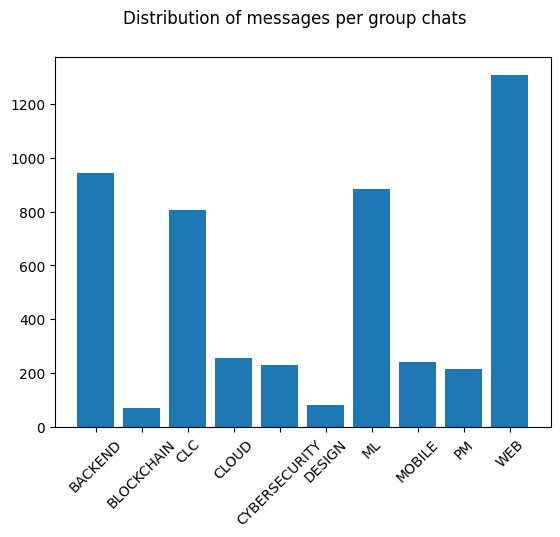

In [21]:
# What group chat had the most messages (exluding the general gc)

counts = df[df.group_chat != 'GENERAL'].groupby('group_chat').message.count()

max_chats_count = counts.max()
max_chats_group = counts[counts == max_chats_count].index[0]

plt.bar(counts.index, height=counts)
plt.suptitle("Distribution of messages per group chats")
plt.xticks(rotation=45)

# make the x labels slanted

max_chats_group, max_chats_count

f"The {max_chats_group} track was most active with {max_chats_count} messages"

## What time and day were members most active at?

(21.0, 2)

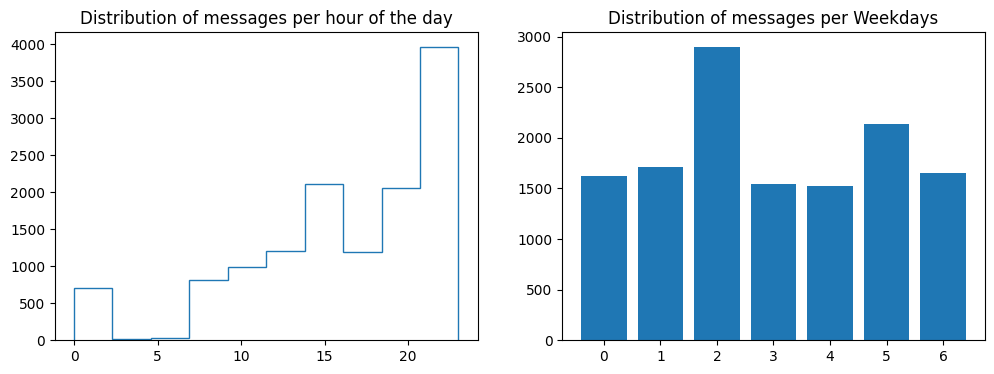

In [22]:


df['date'] = pd.to_datetime(df.date)

df['hour'] = df.date.dt.hour
df['weekday'] = df.date.dt.weekday


# What week day were people most
messages_per_weekday = df.groupby('weekday').message.count()
top_weekdays = messages_per_weekday.sort_values(ascending=False)[:5]


# Plot the data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

hourly_counts, hourly_bins = np.histogram(df.hour)
ax1.stairs(hourly_counts, hourly_bins)

ax1.set_title("Distribution of messages per hour of the day")


ax2.bar(
    messages_per_weekday.index,
    height=messages_per_weekday
)
ax2.set_title("Distribution of messages per Weekdays")


top_hour_idx = np.argmax(hourly_counts)
top_hour = np.round(hourly_bins[top_hour_idx])
top_hour

top_weekday = messages_per_weekday.argmax()

top_hour, top_weekday
# top_hours, top_weekdays

## What members sent the most messages?

In [23]:
# what phone numbers sent the highest number of messages

phone_counts = df.groupby('phone_number').message.count()

phone_counts = phone_counts.sort_values(ascending=False)
# make the x labels slanted

phone_counts[:10]

phone_number
.                                    2078
+234 905 702 6031                    1082
Abolo                                 682
Ajao-Rotimi 👑                         637
Onuada - Web Lead                     571
Adrian (Mobile Dev. Team Lead)        508
Damilola Soji-Oderinde - CLC Lead     493
+234 814 556 4480                     476
+234 810 169 4302                     372
Onofiok ✨                             297
Name: message, dtype: int64

# Message Quantifying.

Before we can gain more useful insights from the data, we need to understand the quality of each message.

We need to be able to score messages based on some criterias

1. Message quality: a score of how relevant the message is. (takes care of heys and his)
2. is_question: probability of text being a question
3. link_count: count of URLS present in the message (Used to quantify if it's a learning resource)

### Quality

Quality will help us rank messages based on how relevant they are to discussions.

We can compute quality by squaring the number of non-stopwords for a message n(Q). we can then divide n(Q) by total number of words n(W).

n(Q)^2 / n(W)

We can get the list of stopwords from the NLTK Library.


<b> Note: </b> This might not be the best way of measuring how impactful a message is as someone could just be saying things that are completely irrelevant (Ads, gist, offensive text, banter) but it's the fastest and most accessible metric

One thing could be to assign extra weights to certain technical words and their synonyms.

Another way to make this metric more effective would be to factor in sentimental analysis to downscore messages that are not positive / offensive

In [24]:
stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}


def compute_quality_score(string: str):

    words = word_tokenize(string.lower())
    words = {word for word in words if word.isalpha()}

    len_good_words = len(words - stopwords)
    len_words = len(words) + 1e-15

    return (len_good_words * len_good_words) / len_words


df['message_quality'] = df.message.map(compute_quality_score)


### Is a message a Question?

We want to know how many questions were asked in the GDSC platform. This helps us have a heuristic idea of how curious GDSC members were.

Although, this isn't such a reliable metric, but it works for what we want to use this data for. Answering questions like: "How many questions did this member ask?"


The objective here is to count how many questions exist in a message by:

1. Breaking the message into sentences.
2. Checking if the message is a sentence.


A bruteforce method can be to check if a question mark was used to terminate the sentence

We can train a simple Naive Bayes Classification model or Decsion tree to make this capture questions without the question mark exclamation.

In [25]:

def count_questions(string: str):

    sentences = sent_tokenize(string)

    questions = filter(lambda sen: sen.endswith('?'), sentences)

    return len(list(questions))


df['no_of_questions'] = df.message.apply(count_questions)

df.head()


,group_chat,date,phone_number,message,hour,weekday,message_quality,no_of_questions
0,ML,2023-09-04 19:14:00,"Anjola Ajayi Co-Lead. DS, ML & AI.",This message was deleted,19,0,1.000000,0
2,ML,2023-09-07 08:41:00,+234 813 675 7509,😭😂😂😂,8,3,0.000000,0
3,ML,2023-09-08 01:44:00,.,https//www.youtube.com/watch?v=IOMO-kcqxJ8&lis...,1,4,0.000000,0
4,ML,2023-09-08 01:45:00,.,https//www.youtube.com/watch?v=dNZXLH4xeAs,1,4,0.000000,0
5,ML,2023-09-08 13:19:00,Ebereonwu,So you’ve trained your model and you like the ...,13,4,4.347826,1


### Link Count.

It's also helpful for us to know how many links exist in a message.

This helps us measure how resourceful GDSC members are and rank them.

We can use this to know:
    
1. The most resourceful GDSC members
2. The most resourceful GDSC members per track

For each GDSC Member, we can know the percentile a member falls into when it comes to answering questions

In [26]:
# match with popular top level domains with exceptions from shortened URLs
link_pattern = re.compile(r"\b(?!(?:goo\.gle|youtu\.be|bit\.ly|forms\.gle))(?:https?://)?(?:www\.)?(?!goo\.gle|youtu\.be|bit\.ly|forms\.gle)[a-zA-Z0-9.-]+\.(?:com(?:\.[a-zA-Z]{2})?|net|org|io|dev|com\.ng|ng|co|google|app)(?:\/[^\s]*)?\b")

def count_links(string: str):

    links = set(re.findall(link_pattern, string))

    n_links = len(links)

    return n_links


df['link_count'] = df.message.apply(count_links)
df.head()


,group_chat,date,phone_number,message,hour,weekday,message_quality,no_of_questions,link_count
0,ML,2023-09-04 19:14:00,"Anjola Ajayi Co-Lead. DS, ML & AI.",This message was deleted,19,0,1.000000,0,0
2,ML,2023-09-07 08:41:00,+234 813 675 7509,😭😂😂😂,8,3,0.000000,0,0
3,ML,2023-09-08 01:44:00,.,https//www.youtube.com/watch?v=IOMO-kcqxJ8&lis...,1,4,0.000000,0,1
4,ML,2023-09-08 01:45:00,.,https//www.youtube.com/watch?v=dNZXLH4xeAs,1,4,0.000000,0,1
5,ML,2023-09-08 13:19:00,Ebereonwu,So you’ve trained your model and you like the ...,13,4,4.347826,1,1


## Member only Stats

Here, given the data we have on the messages, we wish to gain some insights for each member.

Assuming that I'm a GDSC member, these insights may look like this:
    
1. "I was most active in ____ track"
2. "I sent a total of ___ messages more than __% of GDSC members"
3. "Night Crawler: I was more active in the GDSC Community at _pm"
4. "I sent a total of ___ links, more than _% of GDSC members"
5. "I asked a total of ___ questions, more than _% of GDSC members"
6. "You're in the top _% of GDSC members in impactful messaging."

7. "I attended \___ out of \___ GDSC events, more than _% of GDSC members"

In [27]:
# Define the thresholds for top % values
thresholds = [99.5, 99, 95, 90, 80, 70]  # Thresholds for %

# Define corresponding labels for top % groups
top_perc_labels = [f'Top {round(100 - threshold, 2)}%' for threshold in thresholds]

def get_perc_rank_series(percentiles):

    conditions = [percentiles >= threshold for threshold in thresholds]

    top_percent = np.select(conditions, top_perc_labels, default='Not in Top %')

    return top_percent

### Most active members per track

In [28]:
### Most active in track per number

group_phoneno_counts = df.groupby(['group_chat', 'phone_number']).message.count()

group_chats = group_phoneno_counts.index.levels[0]

idx = (group_phoneno_counts[group_chat].argmax() for group_chat in group_chats)

most_active_members_per_track = [
    {
        'phone_number': group_phoneno_counts[group_chat].index[i],
        'message_count': group_phoneno_counts[group_chat][i],
        'group_chat': group_chat
    }
    for group_chat, i in zip(group_chats, idx)
]


### Total messages and % of people I outperformed on this metric

In [29]:
# Total messages and % of people I outperformed on this metric
# What percentile did each member's message count fall into?


phone_groups = df.groupby('phone_number')
phone_message_counts = phone_groups.message.count()

messages_stats = pd.DataFrame({
    'phone_number': phone_message_counts.index,
    'number_of_messages_sent': phone_message_counts.values,
    'percentile_messages': phone_message_counts.rank(pct=True) * 100
})


messages_top_perc = get_perc_rank_series(messages_stats.percentile_messages)
messages_stats['messages_top_perc'] = messages_top_perc

messages_stats.index = range(0, messages_stats.shape[0])
messages_stats = messages_stats.round(2)

messages_stats.sort_values(ascending=False, by='percentile_messages').iloc[:10]


,phone_number,number_of_messages_sent,percentile_messages,messages_top_perc
317,.,2078,100.00,Top 0.5%
250,+234 905 702 6031,1082,99.73,Top 0.5%
319,Abolo,682,99.47,Top 1%
323,Ajao-Rotimi 👑,637,99.20,Top 1%
360,Onuada - Web Lead,571,98.93,Top 5%
322,Adrian (Mobile Dev. Team Lead),508,98.66,Top 5%
331,Damilola Soji-Oderinde - CLC Lead,493,98.40,Top 5%
162,+234 814 556 4480,476,98.13,Top 5%
109,+234 810 169 4302,372,97.86,Top 5%
358,Onofiok ✨,297,97.59,Top 5%


### What time of day was I most active at, What was my peak weekday and hour.

In [30]:
# What time of day was I most active at
# What weekday am I most active at
# What was my peak messaging moment. The day I sent the most messages


time_stats = pd.DataFrame(columns=['phone_number', 'peak_weekday', 'peak_hour', 'peak_day_and_hour'])


time_stats['phone_number'] = df.phone_number.unique()


# Peak WeekDays
weekday_count = df.groupby(['phone_number', 'weekday']).message.size()
idx = (weekday_count[phone_no].argmax() for phone_no in time_stats.phone_number)

time_stats['peak_weekday'] = [
    weekday_count[phone_no].index[i]
    for i, phone_no in zip(
        idx,
        time_stats.phone_number
    )
]


# Peak Hours
hour_count = df.groupby(['phone_number', 'hour']).message.size()
idx = (hour_count[phone_no].argmax() for phone_no in time_stats.phone_number)

time_stats['peak_hour'] = [
    hour_count[phone_no].index[i]
    for i, phone_no in zip(
        idx,
        time_stats.phone_number
    )
]


# Peak Day and Hour
df['date_hour'] = df.date.dt.floor('T')

date_count = df.groupby(['phone_number', 'date_hour']).message.size()
idx = (date_count[phone_no].argmax() for phone_no in time_stats.phone_number)

peak_day_and_hour = (
    date_count[phone_no].index[i]
    for i, phone_no in zip(
        idx,
        time_stats.phone_number
    )
)

time_stats['peak_day_and_hour'] = [
    f"{calendar.month_name[date.month]}, {date.day}, {date.year} at {date.hour}:00"
    for date in peak_day_and_hour
]


# Clean up dataframe
df = df.drop(['date_hour'], axis=1)
time_stats

,phone_number,peak_weekday,peak_hour,peak_day_and_hour
0,"Anjola Ajayi Co-Lead. DS, ML & AI.",2,12,"October, 22, 2023 at 19:00"
1,+234 813 675 7509,6,16,"August, 11, 2023 at 16:00"
2,.,2,20,"October, 25, 2023 at 14:00"
3,Ebereonwu,1,12,"June, 20, 2023 at 12:00"
4,Abolo,2,15,"October, 25, 2023 at 14:00"
...,...,...,...,...
369,+234 903 436 6844,3,21,"October, 19, 2023 at 21:00"
370,+234 806 999 9680,2,20,"October, 19, 2023 at 23:00"
371,+234 703 312 6462,2,18,"October, 25, 2023 at 18:00"
372,+234 705 118 0822,1,20,"November, 7, 2023 at 20:00"


### Total link_count and % of people I outperformed on this metric

In [31]:
# Total link_count and % of people I outperformed on this metric


phone_groups = df.groupby('phone_number')
phone_link_counts = phone_groups.link_count.sum()

resources_stats = pd.DataFrame({
    'phone_number': phone_link_counts.index,
    'number_of_links': phone_link_counts.values,
    'percentile_links': phone_link_counts.rank(pct=True) * 100
})


resources_top_perc = get_perc_rank_series(resources_stats.percentile_links)
resources_stats['resources_top_perc'] = resources_top_perc
# phone_link_counts.describe()

resources_stats.index = range(0, resources_stats.shape[0])
resources_stats = resources_stats.round(2)

resources_stats.sort_values(ascending=False, by='percentile_links')

,phone_number,number_of_links,percentile_links,resources_top_perc
317,.,54,100.00,Top 0.5%
360,Onuada - Web Lead,24,99.73,Top 0.5%
322,Adrian (Mobile Dev. Team Lead),18,99.47,Top 1%
319,Abolo,16,99.20,Top 1%
331,Damilola Soji-Oderinde - CLC Lead,15,98.93,Top 5%
...,...,...,...,...
135,+234 812 436 3539,0,36.10,Not in Top %
134,+234 812 352 4860,0,36.10,Not in Top %
133,+234 812 346 3021,0,36.10,Not in Top %
131,+234 812 221 7946,0,36.10,Not in Top %


### Total questions asked and % of people I outperformed on this metric

In [32]:
# Total questions asked and % of people I outperformed on this metric


phone_groups = df.groupby('phone_number')
phone_question_counts = phone_groups.no_of_questions.sum()


questions_stats = pd.DataFrame({
    'phone_number': phone_question_counts.index,
    'number_of_questions': phone_question_counts.values,
    'percentile_questions': phone_question_counts.rank(pct=True) * 100
})



questions_top_perc = get_perc_rank_series(questions_stats.percentile_questions)
questions_stats['questions_top_perc'] = questions_top_perc


questions_stats.index = range(0, questions_stats.shape[0])
questions_stats = questions_stats.round(2)

questions_stats.sort_values(ascending=False, by='percentile_questions')

,phone_number,number_of_questions,percentile_questions,questions_top_perc
317,.,287,100.00,Top 0.5%
360,Onuada - Web Lead,116,99.73,Top 0.5%
331,Damilola Soji-Oderinde - CLC Lead,70,99.47,Top 1%
93,+234 808 773 1234,54,99.20,Top 1%
250,+234 905 702 6031,47,98.93,Top 5%
...,...,...,...,...
216,+234 902 264 8130,0,31.28,Not in Top %
217,+234 902 281 5525,0,31.28,Not in Top %
218,+234 902 309 4110,0,31.28,Not in Top %
219,+234 902 478 8792,0,31.28,Not in Top %


### Total impact score % of people I outperformed on this metric

In [33]:
# Total impact score and % of people I outperformed on this metric
# We can use the message quality to quantify how impactful a GDSC member was
# by computing the mean impact score.

# Perform grouping
phone_groups = df.groupby('phone_number')
phone_impact_sum = phone_groups.message_quality.sum()

# normalize phone impact sum so we get a good reflection of consistency over the days
n_days = df.date.dt.date.nunique()
phone_impact_sum = phone_impact_sum / n_days


impact_stats = pd.DataFrame({
    'phone_number': phone_impact_sum.index,
    'message_impact_score': phone_impact_sum.values,
    'percentile_impact': phone_impact_sum.rank(pct=True) * 100
})


impact_top_perc = get_perc_rank_series(impact_stats.percentile_impact)
impact_stats['message_impact_top_perc'] = impact_top_perc


impact_stats.index = range(0, impact_stats.shape[0])
impact_stats = impact_stats.round(2)

impact_stats.sort_values(ascending=False, by='percentile_impact')

,phone_number,message_impact_score,percentile_impact,message_impact_top_perc
317,.,36.77,100.00,Top 0.5%
319,Abolo,15.23,99.73,Top 0.5%
250,+234 905 702 6031,12.68,99.47,Top 1%
360,Onuada - Web Lead,9.34,99.20,Top 1%
331,Damilola Soji-Oderinde - CLC Lead,5.73,98.93,Top 5%
...,...,...,...,...
284,+234 909 161 8463,0.00,3.88,Not in Top %
143,+234 813 034 7702,0.00,3.88,Not in Top %
145,+234 813 090 4202,0.00,3.88,Not in Top %
275,+234 907 328 7098,0.00,3.88,Not in Top %


### Total events attended and % of people I outperformed on this metric

In [34]:
# Total events attended and % of people I outperformed on this metric
# for this we will need to join with the data from the GDSC Events portal.


# Should be a pandas dataframe of phone_number, number of events attended and percentile
events_attended_stats = pd.DataFrame(columns=['phone_number', 'number_of_events_attended', 'percentile_events'])

events_attended_top_perc = get_perc_rank_series(events_attended_stats.percentile_events)
events_attended_stats['events_attended_top_perc'] = events_attended_top_perc

# Putting it all together

Here, we package and export the results from the analysis as a JSON file

In [35]:
# member stats

stats = [
    resources_stats,
    questions_stats,
    impact_stats,
    time_stats
]


member_stats = messages_stats
for stat in stats:

    member_stats = member_stats.merge(stat, on='phone_number')

member_stats.index = member_stats.pop('phone_number')



print("Overall top 10. Oppor")
member_stats.sort_values(
    by=['percentile_messages', 'percentile_links', 'percentile_questions', 'percentile_impact'],
    ascending=False
)[:10]

Overall top 10. Oppor


,number_of_messages_sent,percentile_messages,messages_top_perc,number_of_links,percentile_links,resources_top_perc,number_of_questions,percentile_questions,questions_top_perc,message_impact_score,percentile_impact,message_impact_top_perc,peak_weekday,peak_hour,peak_day_and_hour
phone_number,,,,,,,,,,,,,,,
.,2078,100.00,Top 0.5%,54,100.00,Top 0.5%,287,100.00,Top 0.5%,36.77,100.00,Top 0.5%,2,20,"October, 25, 2023 at 14:00"
+234 905 702 6031,1082,99.73,Top 0.5%,11,97.59,Top 5%,47,98.93,Top 5%,12.68,99.47,Top 1%,2,23,"June, 21, 2023 at 23:00"
Abolo,682,99.47,Top 1%,16,99.20,Top 1%,36,98.66,Top 5%,15.23,99.73,Top 0.5%,2,15,"October, 25, 2023 at 14:00"
Ajao-Rotimi 👑,637,99.20,Top 1%,5,94.92,Top 10%,17,96.26,Top 5%,4.19,98.13,Top 5%,5,21,"July, 15, 2023 at 23:00"
Onuada - Web Lead,571,98.93,Top 5%,24,99.73,Top 0.5%,116,99.73,Top 0.5%,9.34,99.20,Top 1%,5,21,"September, 8, 2023 at 23:00"
Adrian (Mobile Dev. Team Lead),508,98.66,Top 5%,18,99.47,Top 1%,33,98.40,Top 5%,5.26,98.66,Top 5%,0,13,"June, 22, 2023 at 15:00"
Damilola Soji-Oderinde - CLC Lead,493,98.40,Top 5%,15,98.93,Top 5%,70,99.47,Top 1%,5.73,98.93,Top 5%,2,21,"December, 1, 2023 at 22:00"
+234 814 556 4480,476,98.13,Top 5%,1,78.74,Top 30%,29,97.86,Top 5%,3.84,97.59,Top 5%,2,21,"June, 21, 2023 at 23:00"
+234 810 169 4302,372,97.86,Top 5%,12,98.26,Top 5%,13,95.59,Top 5%,3.98,97.86,Top 5%,5,23,"July, 4, 2023 at 22:00"


In [36]:
# member_stats
# member_stats.transpose().to_dict()

In [37]:
general_stats = {
    'most_active_group': {'group': max_chats_group, 'number_of_messages': max_chats_count},
    'most_active_time': {'hour': top_hour, 'weekday': calendar.day_name[top_weekday]},
    'most_active_members': phone_counts[:10].to_dict(),
    'most_active_members_per_track': most_active_members_per_track,
}


# general_stats

In [38]:
result = {
    'general_wrapped': general_stats,
    'members_wrappped': member_stats.transpose().to_dict()
}


In [39]:
def default_encoder(object):

    if isinstance(object, np.int64):
        return int(object)

    raise ValueError(f"{type(object)} wasn't handled")


with open('results.json', 'w') as f:

    f.write(json.dumps(result, default=default_encoder))
